DATASET LOADING

In [1]:
# ---- 1. DATASET LOADING ----
import pandas as pd

# Load dataset
df = pd.read_csv("cybersecurity_intrusion_data.csv")
print("Dataset shape:", df.shape)
print("First 5 rows:")
print(df.head())


Dataset shape: (9537, 11)
First 5 rows:
  session_id  network_packet_size protocol_type  login_attempts  \
0  SID_00001                  599           TCP               4   
1  SID_00002                  472           TCP               3   
2  SID_00003                  629           TCP               3   
3  SID_00004                  804           UDP               4   
4  SID_00005                  453           TCP               5   

   session_duration encryption_used  ip_reputation_score  failed_logins  \
0        492.983263             DES             0.606818              1   
1       1557.996461             DES             0.301569              0   
2         75.044262             DES             0.739164              2   
3        601.248835             DES             0.123267              0   
4        532.540888             AES             0.054874              1   

  browser_type  unusual_time_access  attack_detected  
0         Edge                    0                

DATA CLEANING

In [3]:
# ---- 2. DATA CLEANING ----
# Drop irrelevant columns like session_id
if "session_id" in df.columns:
    df.drop(columns=["session_id"], inplace=True)

# Check for missing values
print(df.isnull().sum())

# Drop duplicates if any
df.drop_duplicates(inplace=True)

# Handle missing values (example: fill numerical with median, categorical with mode)
num_cols = df.select_dtypes(include=["int64","float64"]).columns
cat_cols = df.select_dtypes(include=["object","category"]).columns

for col in num_cols:
    df[col].fillna(df[col].median(), inplace=True)

for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

print("After cleaning, dataset shape:", df.shape)



network_packet_size    0
protocol_type          0
login_attempts         0
session_duration       0
encryption_used        0
ip_reputation_score    0
failed_logins          0
browser_type           0
unusual_time_access    0
attack_detected        0
dtype: int64
After cleaning, dataset shape: (9537, 10)


/tmp/ipython-input-3181035350.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipython-input-3181035350.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

DATA PREPROCESSING

In [5]:
# ---- 3. DATA PREPROCESSING ----
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE

# Separate features and target
X = df.drop(columns=["attack_detected"])  # target column
y = df["attack_detected"]

# Redefine numerical & categorical columns based on X only
num_cols = X.select_dtypes(include=["int64","float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object","category"]).columns.tolist()

# Encode categorical columns
for col in cat_cols:
    X[col] = LabelEncoder().fit_transform(X[col])

# Scale numerical features
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

print("After SMOTE, class distribution:")
print(y_res.value_counts())



After SMOTE, class distribution:
attack_detected
1    5273
0    5273
Name: count, dtype: int64


EDA

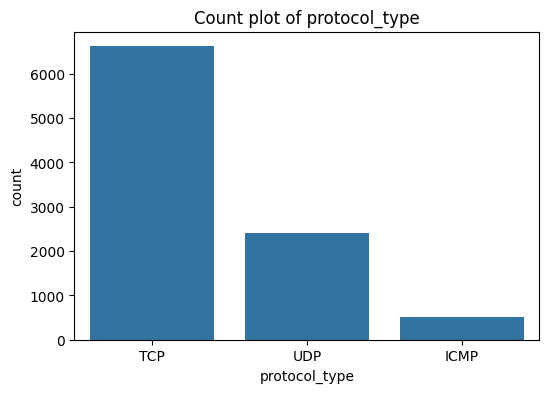

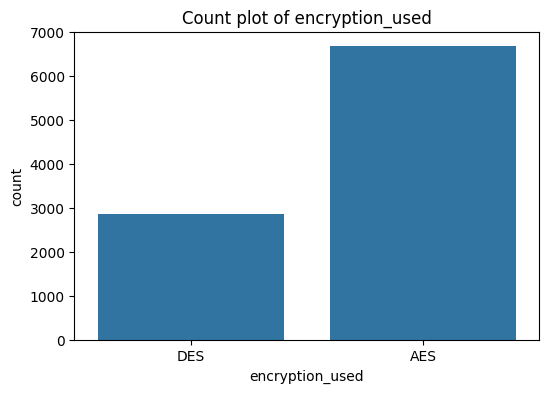

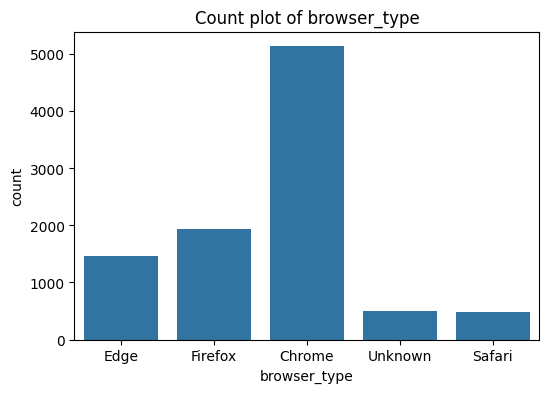

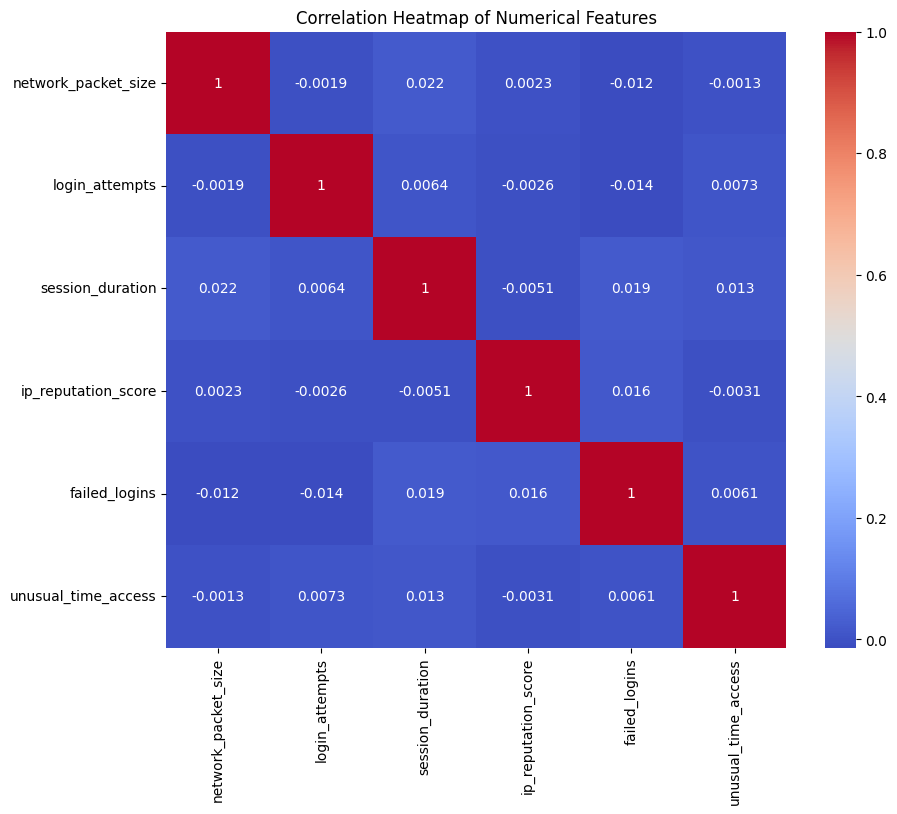

In [6]:
# ---- 4. EDA ----
import matplotlib.pyplot as plt
import seaborn as sns

# Bar plots for categorical columns
for col in cat_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, data=df)
    plt.title(f"Count plot of {col}")
    plt.show()

# Correlation heatmap for numerical features
plt.figure(figsize=(10,8))
sns.heatmap(df[num_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()


TRAIN-TEST SPLIT

In [7]:
# ---- 5. TRAIN-TEST SPLIT ----
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.3, random_state=42, stratify=y_res
)

# Save train/test data
X_train.to_csv("X_train.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

print("Train and test sets saved successfully.")


Train and test sets saved successfully.


MODEL TRAINING

In [8]:
# ---- 6. MODEL TRAINING ----
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Initialize models
pipe_lr = LogisticRegression(max_iter=1000, random_state=42)
pipe_svc = SVC(probability=True, random_state=42)
pipe_rf = RandomForestClassifier(n_estimators=100, random_state=42)
pipe_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train models
pipe_lr.fit(X_train, y_train)
pipe_svc.fit(X_train, y_train)
pipe_rf.fit(X_train, y_train)
pipe_xgb.fit(X_train, y_train)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:49:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

HYPERPARAMETER TUNING

In [18]:
# ---- 6.1 HYPERPARAMETER TUNING ----
from sklearn.model_selection import RandomizedSearchCV

# Random Forest
rf_param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rand_rf = RandomizedSearchCV(pipe_rf, rf_param_dist, n_iter=10, cv=3, scoring='f1', n_jobs=-1, random_state=42)
rand_rf.fit(X_train, y_train)
pipe_rf = rand_rf.best_estimator_
print("Best RF params:", rand_rf.best_params_)

# XGBoost
xgb_param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0]
}
rand_xgb = RandomizedSearchCV(pipe_xgb, xgb_param_dist, n_iter=10, cv=3, scoring='f1', n_jobs=-1, random_state=42)
rand_xgb.fit(X_train, y_train)
pipe_xgb = rand_xgb.best_estimator_
print("Best XGB params:", rand_xgb.best_params_)

# SVM
svc_param_dist = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}
rand_svc = RandomizedSearchCV(pipe_svc, svc_param_dist, n_iter=5, cv=3, scoring='f1', n_jobs=-1, random_state=42)
rand_svc.fit(X_train, y_train)
pipe_svc = rand_svc.best_estimator_
print("Best SVC params:", rand_svc.best_params_)


Best RF params: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:08:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best XGB params: {'subsample': 0.7, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1}
Best SVC params: {'kernel': 'rbf', 'gamma': 'scale', 'C': 10}


FEATURE IMPORTANCE

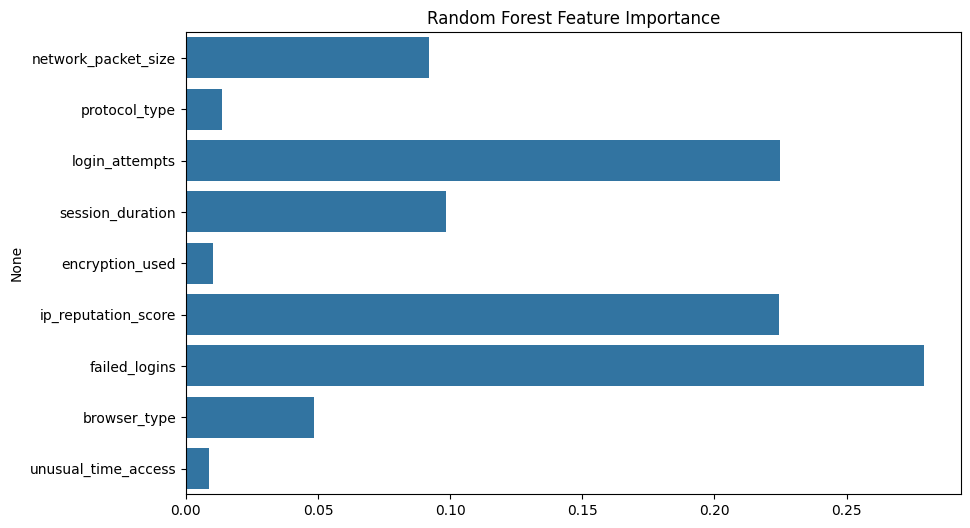

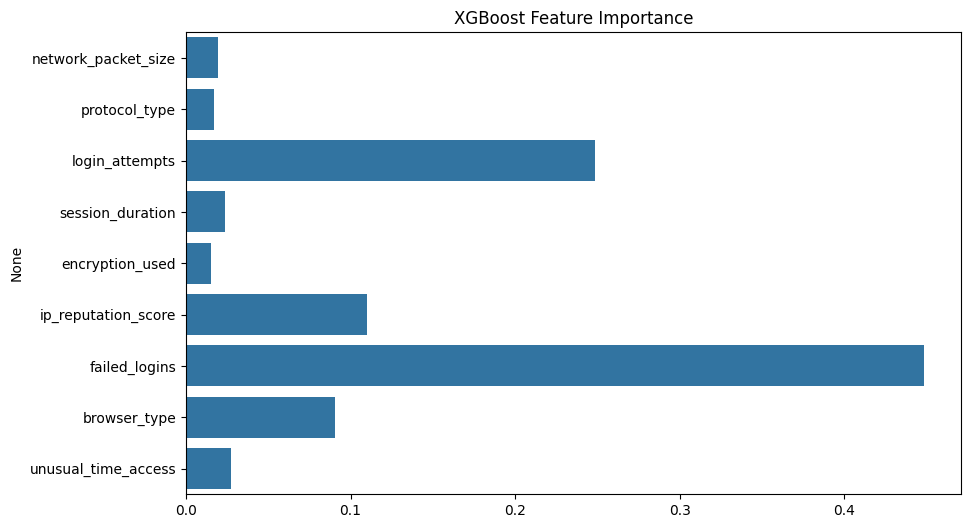

In [19]:
# ---- 7. FEATURE IMPORTANCE ----
importances_rf = pipe_rf.feature_importances_
importances_xgb = pipe_xgb.feature_importances_

feat_names = X_train.columns

# Random Forest
plt.figure(figsize=(10,6))
sns.barplot(x=importances_rf, y=feat_names)
plt.title("Random Forest Feature Importance")
plt.show()

# XGBoost
plt.figure(figsize=(10,6))
sns.barplot(x=importances_xgb, y=feat_names)
plt.title("XGBoost Feature Importance")
plt.show()


In [20]:
# ---- 7.1 FEATURE SELECTION BASED ON IMPORTANCE ----
import numpy as np

# Example for Random Forest
feat_importances = pipe_rf.feature_importances_
importance_threshold = 0.01  # drop features with importance < 1%
selected_features = X_train.columns[feat_importances > importance_threshold]

# Reduce X_train and X_test to selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

print("Selected features after RF importance filtering:")
print(selected_features)


Selected features after RF importance filtering:
Index(['network_packet_size', 'protocol_type', 'login_attempts',
       'session_duration', 'encryption_used', 'ip_reputation_score',
       'failed_logins', 'browser_type'],
      dtype='object')


In [21]:
# Retrain Random Forest on selected features
pipe_rf.fit(X_train_selected, y_train)
# Similarly, retrain XGBoost if desired
pipe_xgb.fit(X_train_selected, y_train)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:11:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [23]:
# ---- AFTER FEATURE SELECTION ----
# Use only the selected features for both training and testing
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Retrain models on selected features
pipe_rf.fit(X_train_selected, y_train)
pipe_xgb.fit(X_train_selected, y_train)
pipe_lr.fit(X_train_selected, y_train)
pipe_svc.fit(X_train_selected, y_train)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:12:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


SVC(C=10, probability=True, random_state=42)

EVALUATION METRICS

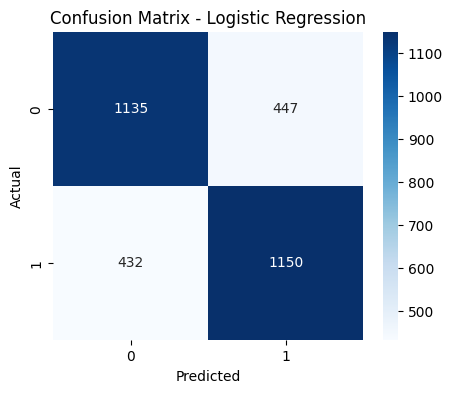

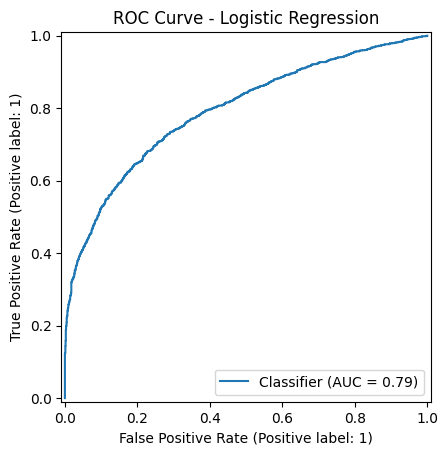

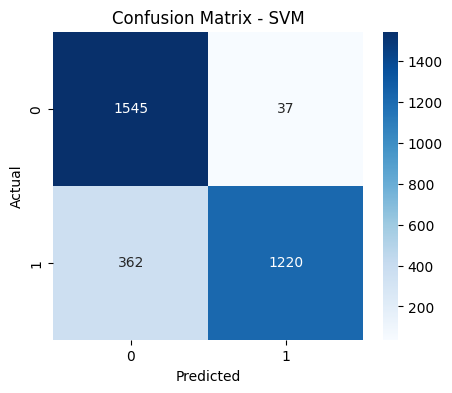

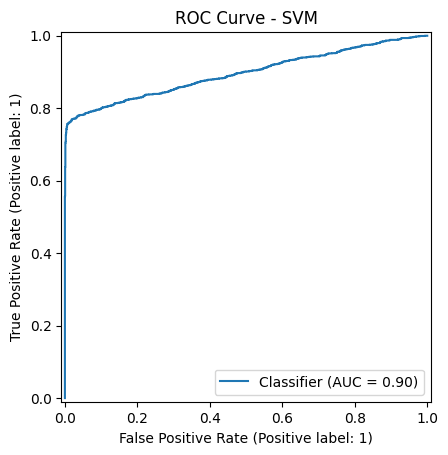

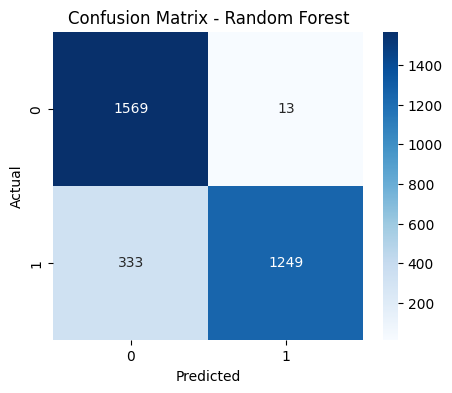

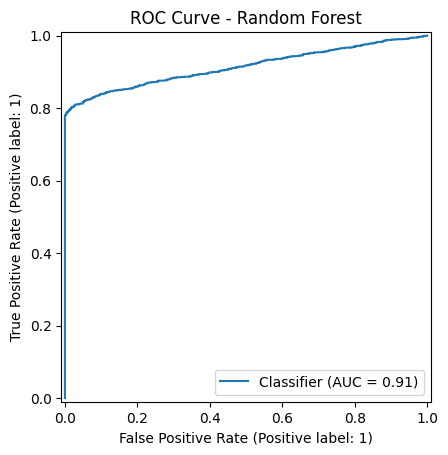

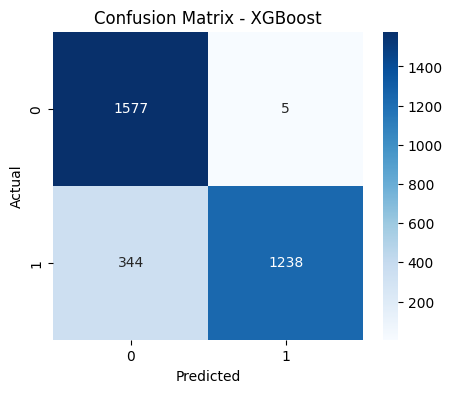

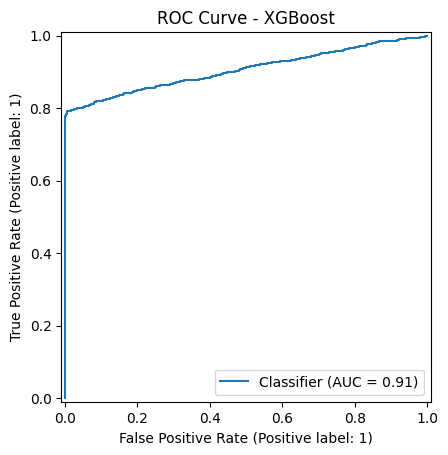

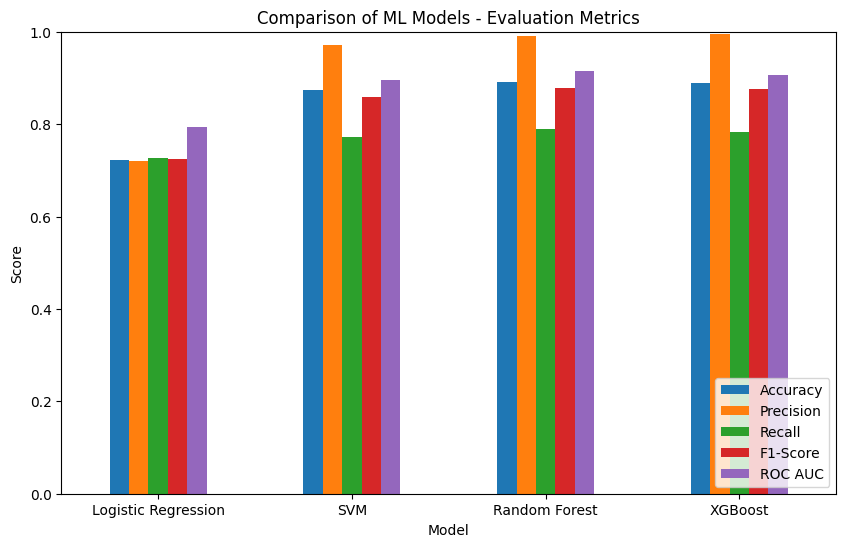

                     Accuracy  Precision    Recall  F1-Score   ROC AUC
Model                                                                 
Logistic Regression  0.722187   0.720100  0.726928  0.723498  0.793358
SVM                  0.873894   0.970565  0.771176  0.859458  0.896285
Random Forest        0.890645   0.989699  0.789507  0.878340  0.914600
XGBoost              0.889697   0.995977  0.782554  0.876460  0.906086


In [24]:
# ---- 8. EVALUATION METRICS (UPDATED) ----
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure test data has the same selected features
# 'selected_features' is from Step 7.1 Feature Selection
X_test_selected = X_test[selected_features]

# Models dictionary
models = {
    "Logistic Regression": pipe_lr,
    "SVM": pipe_svc,
    "Random Forest": pipe_rf,
    "XGBoost": pipe_xgb
}

# List to store metrics
metrics_list = []

for name, model in models.items():
    # Predict
    y_pred = model.predict(X_test_selected)

    # Get probabilities or decision function for ROC AUC
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_selected)[:,1]
    else:
        y_proba = model.decision_function(X_test_selected)

    # Store metrics
    metrics_list.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_proba)
    })

    # Confusion matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    RocCurveDisplay.from_predictions(y_test, y_proba)
    plt.title(f"ROC Curve - {name}")
    plt.show()

# Convert to DataFrame
metrics_df = pd.DataFrame(metrics_list)
metrics_df.set_index("Model", inplace=True)

# Comparison chart
metrics_df.plot(kind="bar", figsize=(10,6))
plt.title("Comparison of ML Models - Evaluation Metrics")
plt.ylabel("Score")
plt.ylim(0,1)
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.show()

# Print metrics table
print(metrics_df)


SAVING XGBOOST MODEL IN PICKLE FILE AND PREDICTING IF THE ATTACK HAPPENED OR NOT

In [26]:
import os
import pickle
import pandas as pd

# ---- 1. Define file paths ----
model_file = "xgb_model.pkl"
features_file = "selected_features.pkl"

# ---- 2. Save model and selected features if not found ----
if not os.path.exists(model_file) or not os.path.exists(features_file):
    print("Pickle files not found. Saving the current trained model and features...")
    # Replace pipe_xgb and selected_features with your trained variables
    with open(model_file, "wb") as f:
        pickle.dump(pipe_xgb, f)
    with open(features_file, "wb") as f:
        pickle.dump(selected_features.tolist(), f)
    print("Files saved successfully.")

# ---- 3. Load model and selected features ----
with open(model_file, "rb") as f:
    xgb_model = pickle.load(f)

with open(features_file, "rb") as f:
    selected_features = pickle.load(f)

# ---- 4. Interactive input function ----
def interactive_attack_prediction():
    print("Enter values for the following features:")

    input_data = {}
    for feature in selected_features:
        while True:
            try:
                value = float(input(f"{feature}: "))
                input_data[feature] = value
                break
            except ValueError:
                print("Please enter a numeric value.")

    # Convert to DataFrame
    input_df = pd.DataFrame([input_data])

    # Predict
    prediction = xgb_model.predict(input_df)[0]
    probability = xgb_model.predict_proba(input_df)[0][1]

    print("\n--- Prediction Result ---")
    print(f"Attack Detected: {'Yes' if prediction == 1 else 'No'}")
    print(f"Probability of Attack: {probability:.4f}")

# ---- 5. Run the interactive function ----
interactive_attack_prediction()


Pickle files not found. Saving the current trained model and features...
Files saved successfully.
Enter values for the following features:
network_packet_size: 804
protocol_type: TCP
Please enter a numeric value.
protocol_type: 1
login_attempts: 6
session_duration: 186.333
encryption_used: 1
ip_reputation_score: 0.6
failed_logins: 3
browser_type: 1

--- Prediction Result ---
Attack Detected: Yes
Probability of Attack: 0.9964
